# Machine Learning - Lifecycle Samples
- Data load -> EDA -> Data Split -> Preprocessing -> Modeling -> Evaluation -> HPO -> Test

## Regression

### (1) Housing dataset

#### Data Load

In [78]:
housing = pd.read_csv('./handson-ml2/datasets/housing/housing.csv')
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


#### Data Split

In [79]:
### 소득 별로 분할하여 Stratified split
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6, np.inf], labels=[1, 2, 3, 4, 5])
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train = housing.loc[train_index]
    strat_test = housing.loc[test_index]
    
for set_ in (strat_train, strat_test):
    set_.drop("income_cat", axis=1, inplace=True)

In [80]:
### split X, y
housing = strat_train.drop("median_house_value", axis=1)
housing_labels = strat_train["median_house_value"].copy()

In [81]:
### pipeline class
num_attribs = list(housing.columns.difference(["ocean_proximity"]))
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

full_pipeline = ColumnTransformer([ # compose
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)

#### Modeling

In [82]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [83]:
### Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [86]:
### Pipeline with modeling
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(housing)

array([ 88983.14806384, 305351.35385026, 153334.71183453, ...,
       221487.30785916, 241041.31494299, 100662.66960931])

In [ ]:
### Another models
# Decision Tree
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

# Random Forest
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

# SVRegressor
svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)

#### Evaluation

In [85]:
### validation
housing_predictions = tree_reg.predict(housing_prepared)
tree_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
print('Decision Tree RMSE:', forest_rmse)

housing_predictions = forest_reg.predict(housing_prepared)
forest_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
print('Random Forest RMSE:', forest_rmse)

housing_predictions = svm_reg.predict(housing_prepared)
svm_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
print('SVR RMSE:', np.sqrt(svm_rmse))

Random Forest RMSE: 18354.32660078079
SVR RMSE: 334.3690761684062


In [90]:
### Cross Validation
def display_scores(scores):
    print("점수:", scores)
    print("평균:", scores.mean())
    print("표준 편차:", scores.std())

print('Tree model')
score = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=3)
tree_rmse_scores = np.sqrt(-score) # error의 경우 부호를 반대로 해야 함
display_scores(tree_rmse_scores)

print('\nLinear Regression model')
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=3)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

print('\nRandom Forest model')
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=3)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

print('\nSVR model')
svr_scores = cross_val_score(svm_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=3)
svr_rmse_scores = np.sqrt(-svr_scores)
display_scores(svr_rmse_scores)

Tree model
점수: [69849.95776875 69185.54836148 70489.07564732]
평균: 69841.52725918274
표준 편차: 532.1961739470247

Linear Regression model
점수: [68499.93941627 70177.76265488 69201.23113026]
평균: 69292.97773380253
표준 편차: 688.0338094636624

Random Forest model
점수: [49823.0556125  50532.45470069 51183.65349122]
평균: 50513.05460147205
표준 편차: 555.6311245051338

SVR model
점수: [112649.49881834 114393.2710437  115034.92596079]
평균: 114025.89860760847
표준 편차: 1007.8979918917704


#### HPO

In [91]:
### Grid search
param_grid = [{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, # 12(=3×4)개의 하이퍼파라미터 조합을 시도합니다.
              {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}] # bootstrap은 False로 하고 6(=2×3)개의 조합을 시도합니다.

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=3, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [92]:
print('best params:', grid_search.best_params_)
print('best estimator:', grid_search.best_estimator_)

best params: {'max_features': 8, 'n_estimators': 30}
best estimator: RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)


In [93]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params) # Grid search 점수 확인

63450.32381122495 {'max_features': 2, 'n_estimators': 3}
55928.62717586398 {'max_features': 2, 'n_estimators': 10}
53602.05766014793 {'max_features': 2, 'n_estimators': 30}
60274.67681804967 {'max_features': 4, 'n_estimators': 3}
53181.17799369876 {'max_features': 4, 'n_estimators': 10}
51088.77876908601 {'max_features': 4, 'n_estimators': 30}
61202.48392403287 {'max_features': 6, 'n_estimators': 3}
53165.830387170696 {'max_features': 6, 'n_estimators': 10}
50853.83092128557 {'max_features': 6, 'n_estimators': 30}
60352.1421257307 {'max_features': 8, 'n_estimators': 3}
52746.277456108925 {'max_features': 8, 'n_estimators': 10}
50727.14790838459 {'max_features': 8, 'n_estimators': 30}
62813.005687821016 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54973.79417527878 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60619.70682327377 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53622.092899649375 {'bootstrap': False, 'max_features': 3, 'n_estimators':

In [94]:
### Randomized search
param_distribs = {'n_estimators': np.random.randint(low=1, high=200, size=10),
                  'max_features': np.random.randint(low=1, high=8, size=10)}

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs, n_iter=10, cv=3, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': array([1, 4, 1, 4, 6, 2, 7, 2, 5, 7]),
                                        'n_estimators': array([ 89,  76,  86,  42, 190, 186, 160, 118, 134, 191])},
                   random_state=42, scoring='neg_mean_squared_error')

In [95]:
from scipy.stats import randint
from scipy.stats import geom, expon

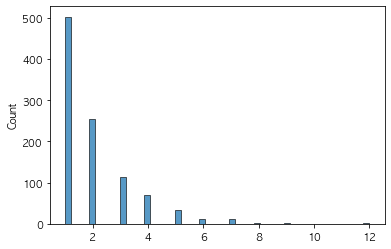

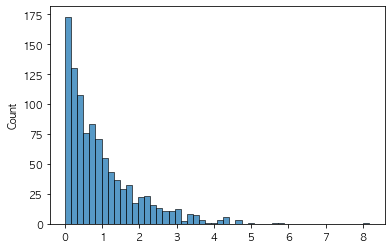

In [96]:
# geom, exponential parameters
geom_distrib = geom(0.5).rvs(1000, random_state=42)
expon_distrib = expon(scale=1).rvs(1000, random_state=42)

sns.distplot(geom_distrib, bins=50)
plt.show()
sns.distplot(expon_distrib, bins=50)
plt.show()

In [97]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

50399.07388517163 {'n_estimators': 42, 'max_features': 5}
53151.49924606481 {'n_estimators': 42, 'max_features': 2}
52500.17992637956 {'n_estimators': 89, 'max_features': 2}
49790.8700008532 {'n_estimators': 186, 'max_features': 6}
49783.103660502886 {'n_estimators': 190, 'max_features': 6}
50126.67179647642 {'n_estimators': 191, 'max_features': 4}
54534.37226514882 {'n_estimators': 86, 'max_features': 1}
49832.77852609296 {'n_estimators': 89, 'max_features': 5}
50394.004875777195 {'n_estimators': 89, 'max_features': 4}
54493.35800093847 {'n_estimators': 89, 'max_features': 1}


In [98]:
### Best model, Feature importance
feature_importances = grid_search.best_estimator_.feature_importances_
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]

cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.4499147620859369, 'median_income'),
 (0.1401204552927923, 'pop_per_hhold'),
 (0.11308431493871018, 'longitude'),
 (0.10100077376373191, 'latitude'),
 (0.04900351622597163, 'housing_median_age'),
 (0.038638281268360365, 'population'),
 (0.030800756442082574, 'total_rooms'),
 (0.028466395086199844, 'total_bedrooms'),
 (0.02585907088468502, 'households'),
 (0.011619867281741325, 'rooms_per_hhold'),
 (0.009239103399093158, 'INLAND'),
 (0.00218027514438822, '<1H OCEAN'),
 (7.242818630655396e-05, 'bedrooms_per_room')]

#### Model Test

In [99]:
### Test set 사용
final_model = grid_search.best_estimator_

x_test = strat_test.drop("median_house_value", axis=1)
y_test = strat_test["median_house_value"].copy()

x_test_prepared = full_pipeline.transform(x_test)
final_predictions = final_model.predict(x_test_prepared)

print(mean_squared_error(y_test, final_predictions, squared=False))

47766.34153125065


In [100]:
# 95% CI for Test RMSE
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
print(np.sqrt(stats.t.interval(confidence, len(squared_errors)-1, loc=squared_errors.mean(), scale=stats.sem(squared_errors))))

# z-score
mean = squared_errors.mean()
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(len(squared_errors))
print(np.sqrt(mean - zmargin), np.sqrt(mean + zmargin))

[45847.46771481 49611.05190076]
45848.04225163724 49610.52094316534


## Classification

### (1) Mnist dataset

In [101]:
from sklearn.datasets import fetch_openml

In [102]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

x, y = mnist["data"], mnist["target"]
print(x.shape, y.shape)

(70000, 784) (70000,)


In [103]:
# y type 변환
y = y.astype(np.uint8)
y

array([5, 0, 4, ..., 4, 5, 6], dtype=uint8)

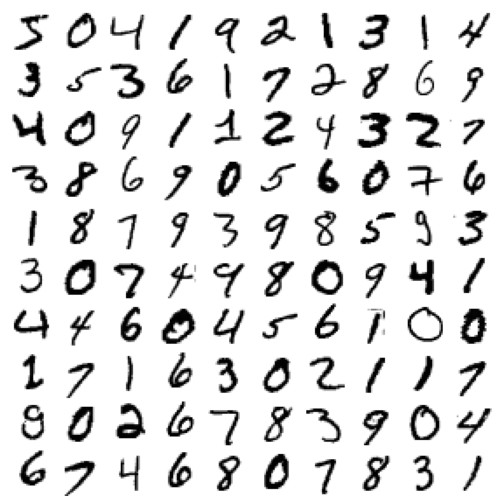

In [104]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=mpl.cm.binary, interpolation="nearest")
    plt.axis("off")

# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일합니다.
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다. 
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size, images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다.
    plt.imshow(big_image, cmap=mpl.cm.binary, **options)
    plt.axis("off")
    
plt.figure(figsize=(9, 9))
example_images = x[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

#### Preprocessing

In [105]:
### Data split
x_train, x_test, y_train, y_test = x[:60000], x[60000:], y[:60000], y[60000:]

In [106]:
### Scaling
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))

#### Modeling - Binary

In [107]:
### Biranry case로 변경
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

In [108]:
from sklearn.linear_model import SGDClassifier

In [109]:
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(x_train_scaled, y_train_5)

SGDClassifier(random_state=42)

#### Evaluation

In [ ]:
### Cross Valication
cross_val_score(sgd_clf, x_train_scaled, y_train_5, cv=3, scoring="accuracy") ### 아래의 Base model과 비교 필요

In [111]:
from sklearn.base import BaseEstimator

In [112]:
### Base model
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, x_train_scaled, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [113]:
y_train_pred = cross_val_predict(sgd_clf, x_train_scaled, y_train_5, cv=3)

In [114]:
confusion_matrix(y_train_5, y_train_pred)

array([[53931,   648],
       [ 1231,  4190]])

In [115]:
print("Precision:", precision_score(y_train_5, y_train_pred))
print("Recall:", recall_score(y_train_5, y_train_pred))
print("F1-score:", f1_score(y_train_5, y_train_pred))

Precision: 0.8660603555188094
Recall: 0.7729201254381111
F1-score: 0.8168437469538942


In [116]:
### score 추출
y_scores = cross_val_predict(sgd_clf, x_train_scaled, y_train_5, cv=3, method="decision_function")

In [117]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

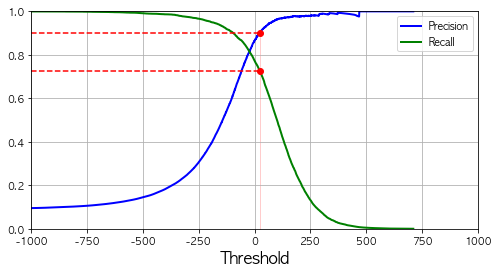

In [118]:
# 90% precision 목표
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))
sns.lineplot(x=thresholds, y=precisions[:-1], color='blue', label="Precision", linewidth=2)
sns.lineplot(x=thresholds, y=recalls[:-1], color='green', label="Recall", linewidth=2)
plt.legend(loc="center right", fontsize=16)
plt.xlabel("Threshold", fontsize=16)
plt.axis([-1000, 1000, 0, 1])   
plt.grid(True) 

sns.lineplot(x=[threshold_90_precision, threshold_90_precision], y=[0., 0.9], color='red', linestyle='dashed')
sns.lineplot(x=[-1000, threshold_90_precision], y=[0.9, 0.9], color='red', linestyle='dashed') 
sns.lineplot(x=[-1000, threshold_90_precision], y=[recall_90_precision, recall_90_precision], color='red', linestyle='dashed')
sns.lineplot(x=[threshold_90_precision], y=[0.9], color='red', linestyle='dashed')
plt.plot([threshold_90_precision], [0.9], "ro")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")
plt.show()

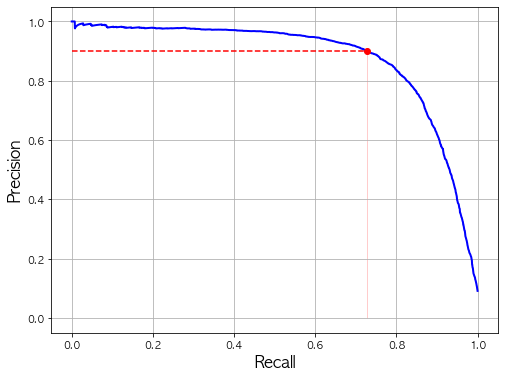

In [119]:
plt.figure(figsize=(8, 6))
sns.lineplot(x=recalls, y=precisions, color="blue", linewidth=2)
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.grid(True)
    
sns.lineplot(x=[recall_90_precision, recall_90_precision], y=[0., 0.9], color='red', linestyle='dashed')
sns.lineplot(x=[0.0, recall_90_precision], y=[0.9, 0.9], color='red', linestyle='dashed')
sns.lineplot(x=[recall_90_precision], y=[0.9], color='red', linestyle='dashed')
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

In [120]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

22.472524841848383

In [121]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

print("Precision:", precision_score(y_train_5, y_train_pred_90))
print("Recall:", recall_score(y_train_5, y_train_pred_90))
print("F1-score:", f1_score(y_train_5, y_train_pred_90))

Precision: 0.9000456412596988
Recall: 0.7275410440878067
F1-score: 0.804651637253902


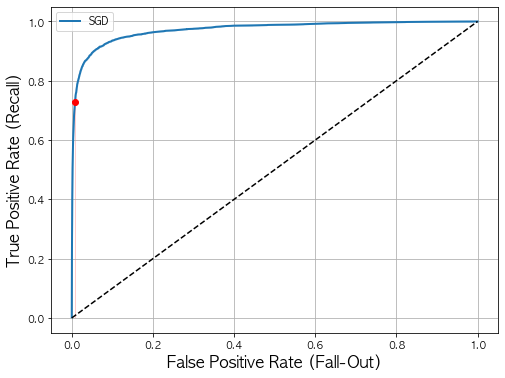

AUC: 0.9726681225154626


In [122]:
### ROC curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

plt.figure(figsize=(8, 6)) 
sns.lineplot(x=fpr, y=tpr, linewidth=2, label='SGD')
sns.lineplot(x=[0, 1], y=[0, 1], color='black', linestyle='dashed') # 대각 점선
plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
plt.ylabel('True Positive Rate (Recall)', fontsize=16)
plt.grid(True)

fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]

sns.lineplot(x=[fpr_90, fpr_90], y=[0., recall_90_precision], color='red', linestyle='dashed')
sns.lineplot(x=[0.0, fpr_90], y=[recall_90_precision, recall_90_precision], color='red', linestyle='dashed')
plt.plot([fpr_90], [recall_90_precision], "ro")  
plt.show()

print('AUC:', roc_auc_score(y_train_5, y_scores))

In [123]:
from sklearn.ensemble import RandomForestClassifier

In [124]:
### Add classifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [125]:
y_train_pred_forest = cross_val_predict(forest_clf, x_train_scaled, y_train_5, cv=3)

print("Precision:", precision_score(y_train_5, y_train_pred_forest))
print("Recall:", recall_score(y_train_5, y_train_pred_forest))
print("F1-score:", f1_score(y_train_5, y_train_pred_forest))

Precision: 0.9905083315756169
Recall: 0.8662608374838591
F1-score: 0.9242275142688446


In [126]:
y_probas_forest = cross_val_predict(forest_clf, x_train_scaled, y_train_5, cv=3, method="predict_proba")

y_scores_forest = y_probas_forest[:, 1] # 점수 = 양성 클래스의 확률
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)
print('AUC:', roc_auc_score(y_train_5, y_scores_forest))

AUC: 0.9983414120257013


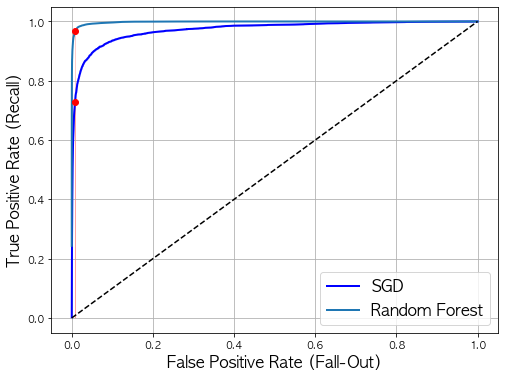

In [127]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
sns.lineplot(x=fpr, y=tpr, color='blue', linewidth=2, label="SGD")
sns.lineplot(x=fpr_forest, y=tpr_forest, linewidth=2, label="Random Forest")
sns.lineplot(x=[0, 1], y=[0, 1], color='black', linestyle='dashed') # 대각 점선
plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
plt.ylabel('True Positive Rate (Recall)', fontsize=16)
plt.grid(True)
    
sns.lineplot(x=[fpr_90, fpr_90], y=[0., recall_90_precision], color='red', linestyle='dashed')
sns.lineplot(x=[0.0, fpr_90], y=[recall_90_precision, recall_90_precision], color='red', linestyle='dashed')
plt.plot([fpr_90], [recall_90_precision], "ro")
sns.lineplot(x=[fpr_90, fpr_90], y=[0., recall_for_forest], color='red', linestyle='dashed')
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()